## Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from scipy.stats import ttest_ind
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV

## Loading Data

First, we load the data and have an overview on the data type of each column.

In [2]:
df = pd.read_csv("alzheimers_disease_data.csv", index_col=0)
df.dtypes

Age                            int64
Gender                         int64
Ethnicity                      int64
EducationLevel                 int64
BMI                          float64
Smoking                        int64
AlcoholConsumption           float64
PhysicalActivity             float64
DietQuality                  float64
SleepQuality                 float64
FamilyHistoryAlzheimers        int64
CardiovascularDisease          int64
Diabetes                       int64
Depression                     int64
HeadInjury                     int64
Hypertension                   int64
SystolicBP                     int64
DiastolicBP                    int64
CholesterolTotal             float64
CholesterolLDL               float64
CholesterolHDL               float64
CholesterolTriglycerides     float64
MMSE                         float64
FunctionalAssessment         float64
MemoryComplaints               int64
BehavioralProblems             int64
ADL                          float64
C

Noticed that the last column `DoctorInCharge` is not numerical and will be not used in the further analysis, so we dropped that column.

In [3]:
# drop the column for doctor in charge
df = df.drop(df.columns[-1], axis=1)

We also checked the null values. There are no missing values in any column.

In [4]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())
# df.fillna(df.mean(), inplace=True)
# df.fillna(df.median(), inplace=True)  

Missing values in each column:
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfu

In order to check the collinearity, we plotted a correlation heatmap to display the correlations between all pairs of features in the dataset. We found that all features are approximately independent.

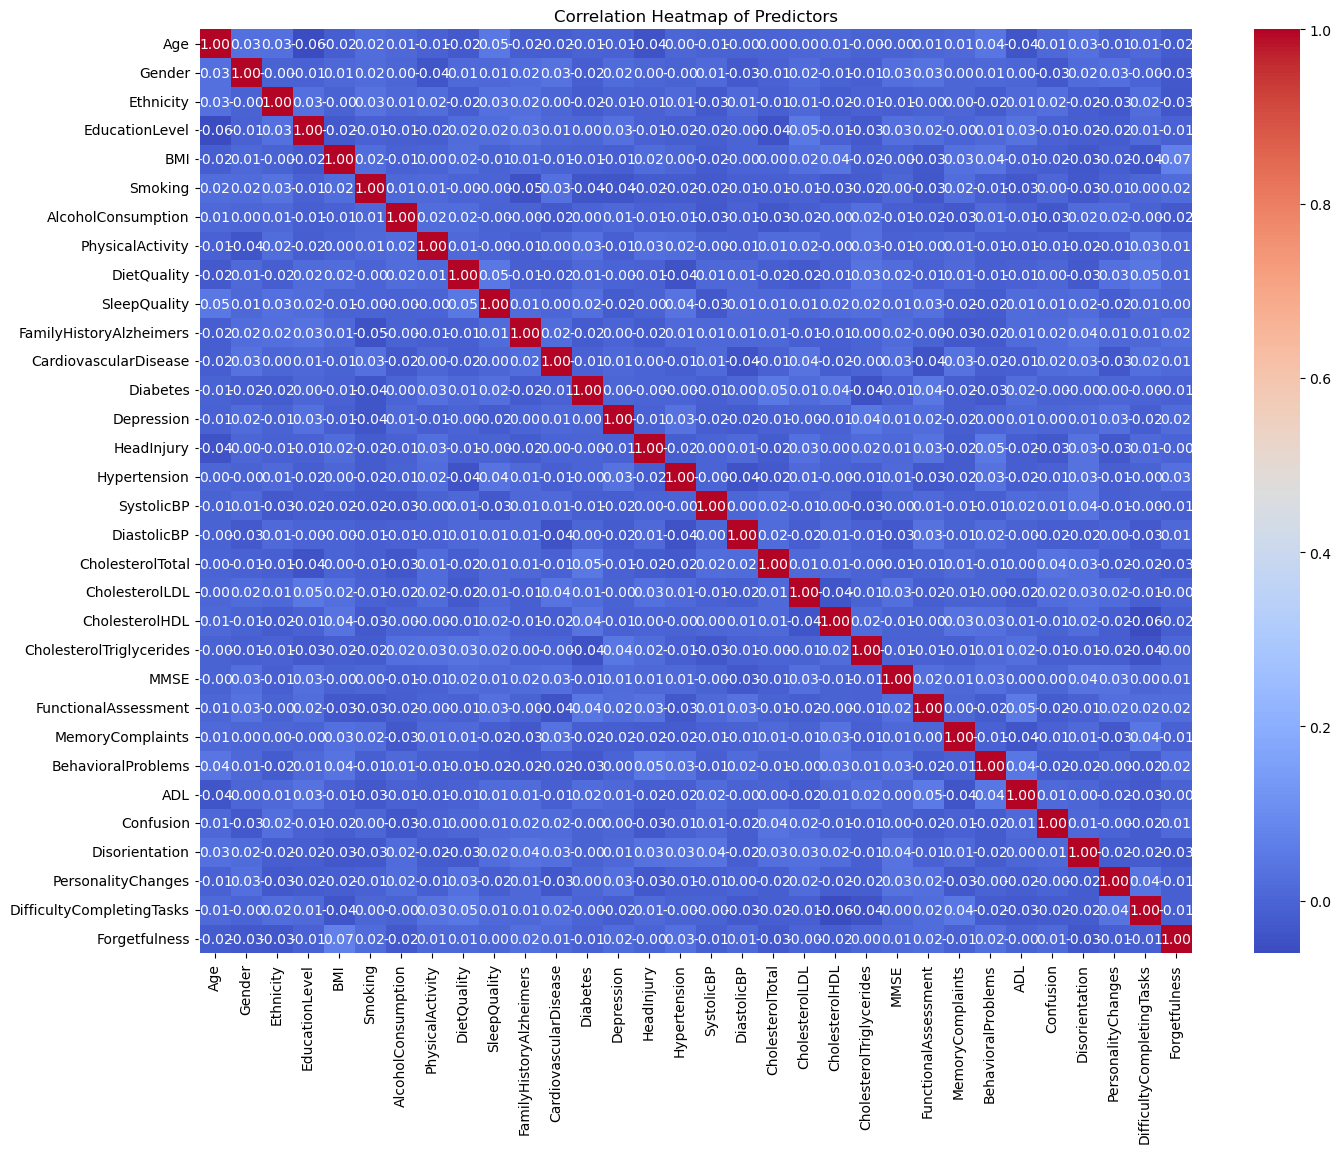

In [5]:
# Exclude target variable
predictors = df.drop(columns=['Diagnosis'])

# Compute correlation matrix
corr_matrix = predictors.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Predictors")
plt.savefig("heatmap.jpg")
plt.show()

In [6]:
# Scaling numerical features
numeric_columns = list(df.select_dtypes('float64').columns) + ['Age', 'SystolicBP', 'DiastolicBP']
scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

## Visualizing Correlations

Then, we used the violin plot to visualize the distributions of all interval and ratio data, separated by the result of diagnosis (where 0 represents non-diagnosed and 1 represents diagnosed).

In [7]:
# List of categorical variables
categorical_groups = [
    'Gender','Ethnicity', 'EducationLevel', 'Smoking', 'FamilyHistoryAlzheimers', 
    'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 
    'Hypertension', 'Confusion', 'Disorientation', 'PersonalityChanges', 
    'DifficultyCompletingTasks', 'Forgetfulness'
]

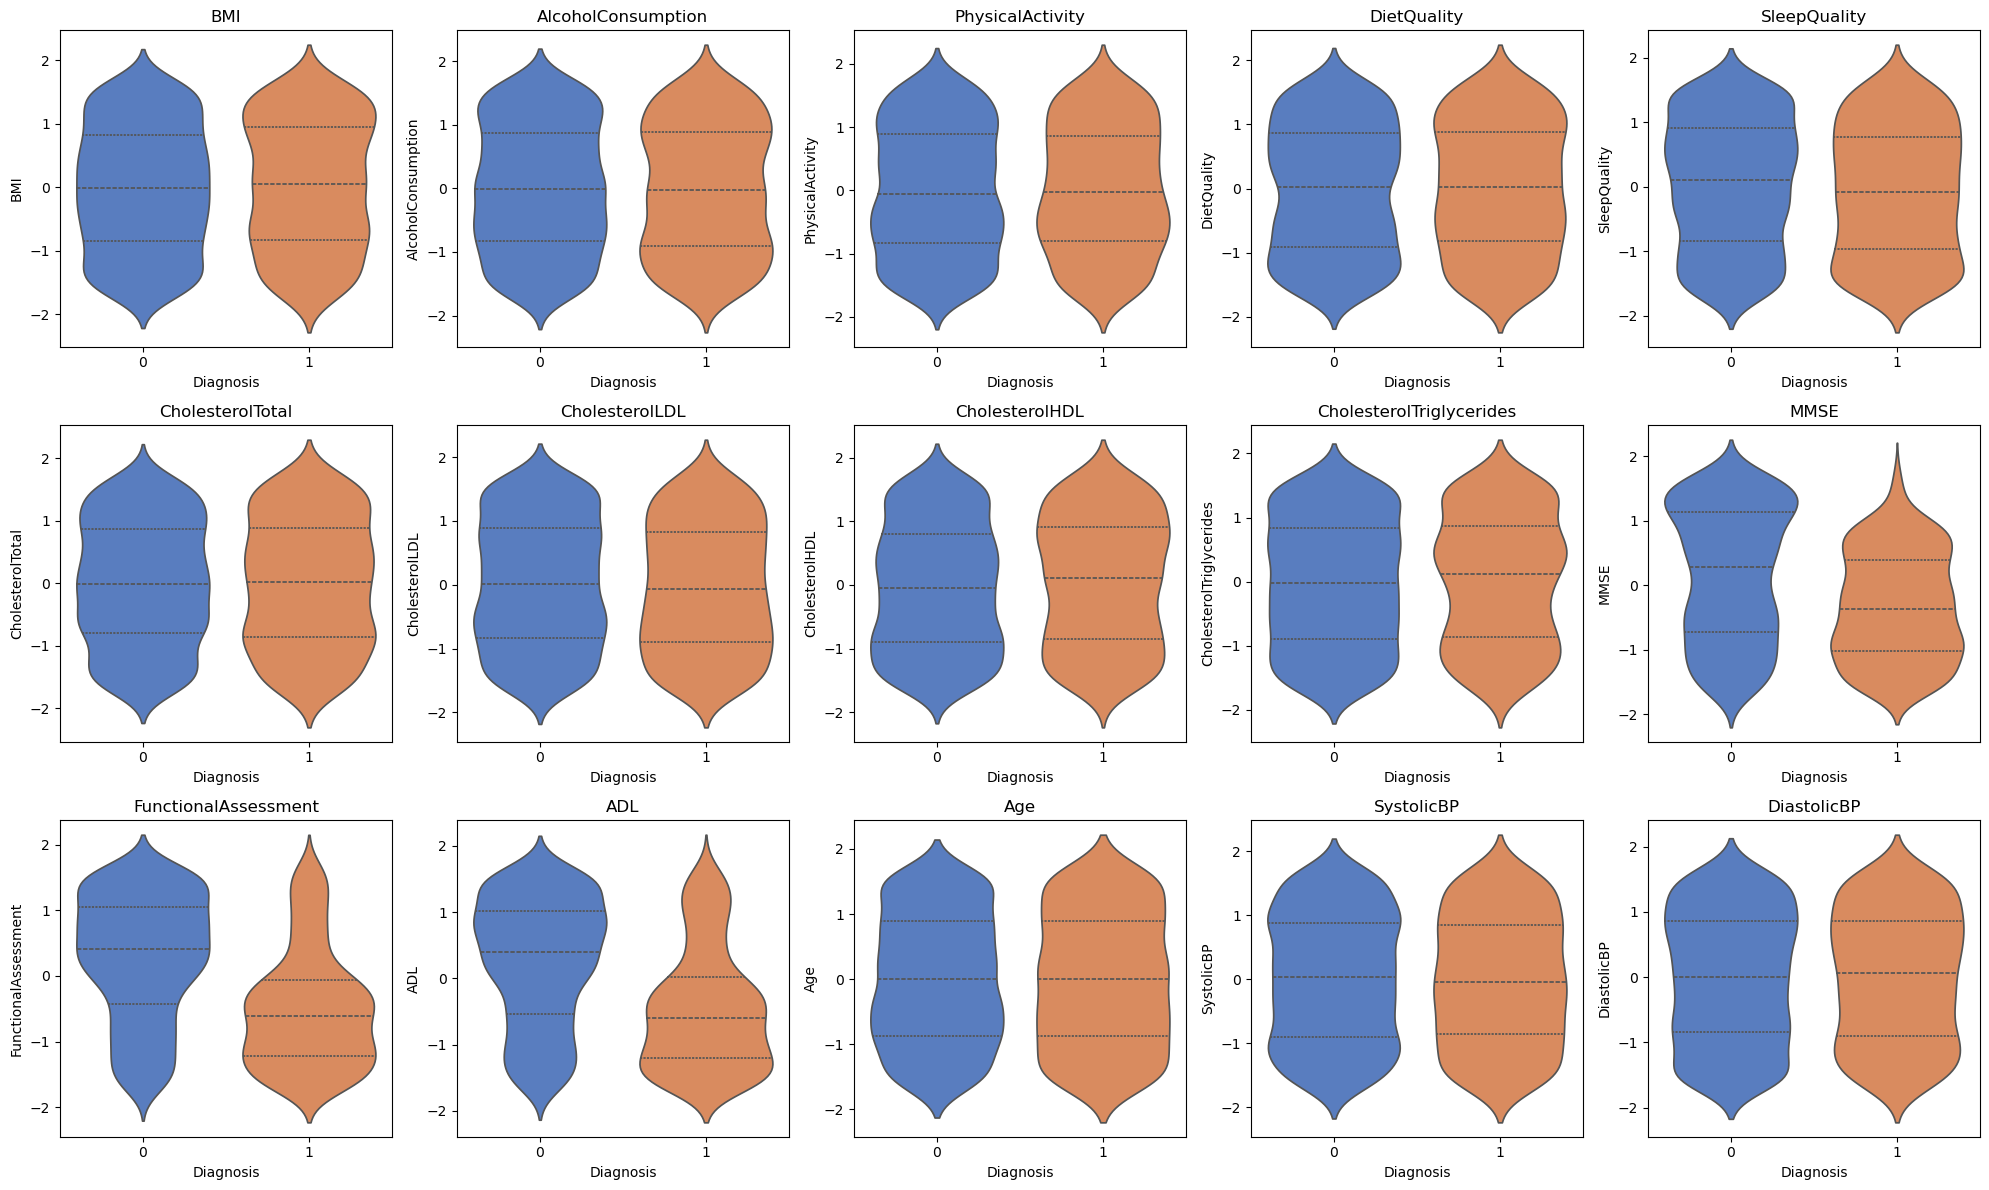

In [8]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

# Loop through each variable and create a violin plot
for i, var in enumerate(numeric_columns):
    ax = axes[i]
    sns.violinplot(data=scaled_df, x='Diagnosis', y=var, inner='quartile', scale='width', palette='muted', ax=ax)
    ax.set_title(f"{var}")
    ax.set_xlabel("Diagnosis")
    ax.set_ylabel(var)
plt.tight_layout()
plt.show()

For the nominative and ordinal data, we used the bar plots to compare the difference between non-diagnosed and diagnosed groups.

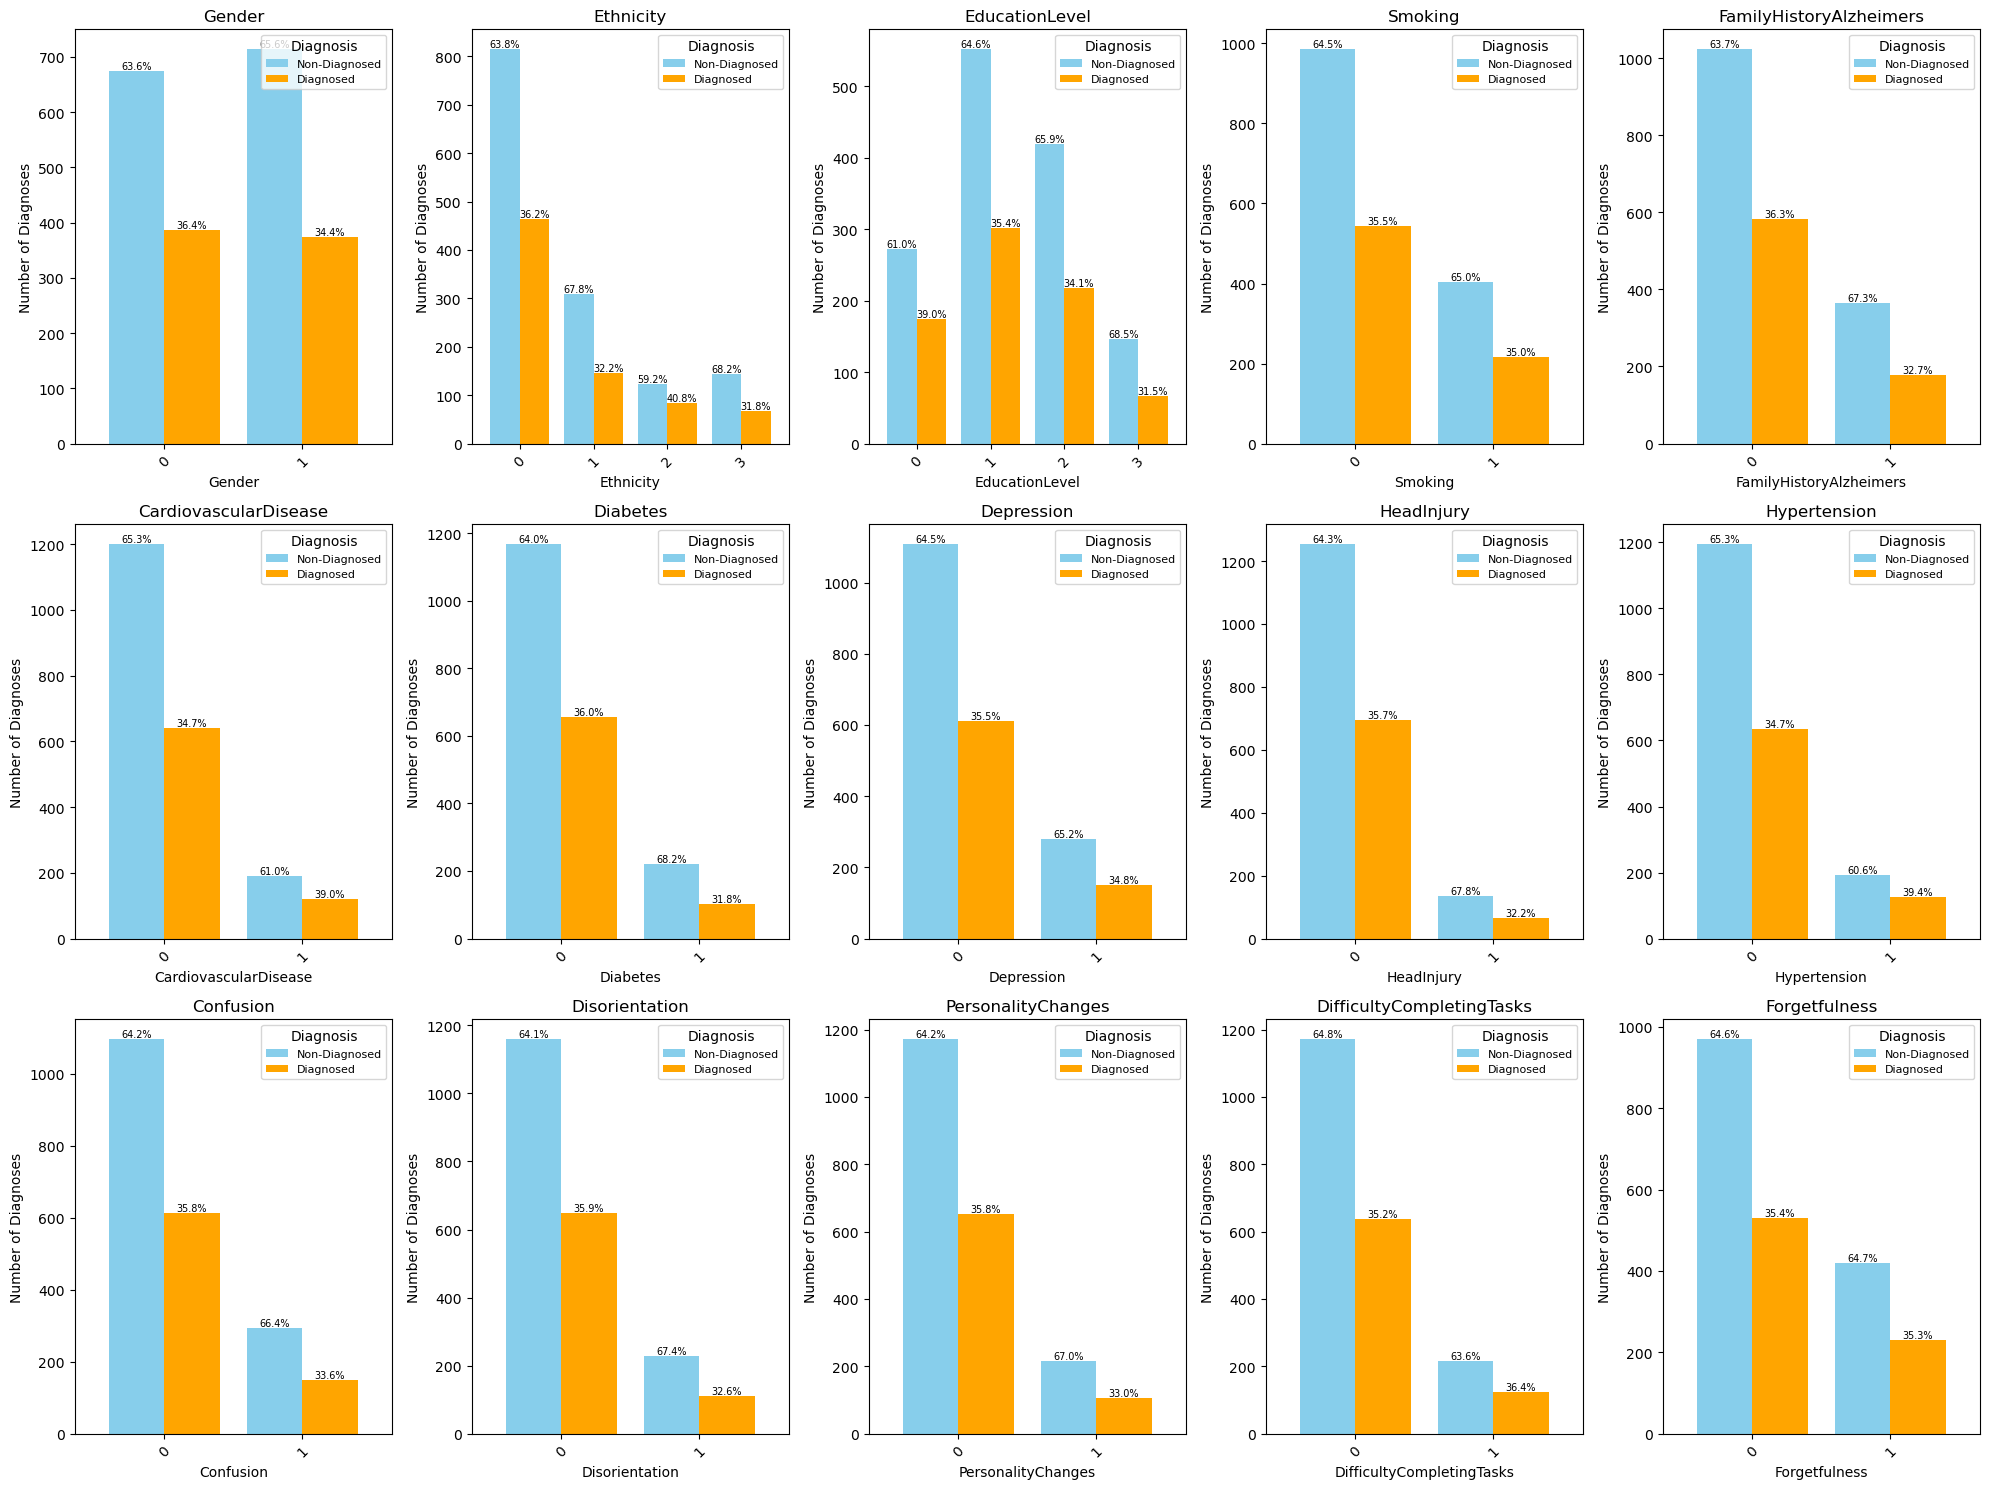

In [9]:
# Create the figure and axes
fig, axes = plt.subplots(3, 5, figsize=(20, 15))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each categorical variable
for i, cat_var in enumerate(categorical_groups):
    ax = axes[i]
    
    # Group data by the categorical variable and Diagnosis
    grouped_data = df.groupby([cat_var, 'Diagnosis']).size().reset_index(name='Count')

    # Calculate total count for each level of the categorical variable
    total_counts = grouped_data.groupby(cat_var)['Count'].transform('sum')
    
    # Calculate the correct percentage for each Diagnosis level
    grouped_data['Percentage'] = (grouped_data['Count'] / total_counts) * 100
    
    # Pivot data for plotting counts and percentages
    pivot_counts = grouped_data.pivot(index=cat_var, columns='Diagnosis', values='Count').fillna(0)
    pivot_percentages = grouped_data.pivot(index=cat_var, columns='Diagnosis', values='Percentage').fillna(0)
    
    # Plot side-by-side bar chart
    pivot_counts.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'orange'])
    
    # Add percentages on the bars
    for bar_group, diagnosis in zip(ax.containers, pivot_percentages.columns):
        for bar, category in zip(bar_group, pivot_counts.index):
            height = bar.get_height()
            if height > 0:  # Only label bars with a positive height
                percentage = pivot_percentages.loc[category, diagnosis]
                ax.annotate(f'{percentage:.1f}%', 
                            (bar.get_x() + bar.get_width() / 2, height), 
                            ha='center', va='bottom', fontsize=7, color='black')

    # Titles and labels
    ax.set_title(f"{cat_var}")
    ax.set_xlabel(cat_var)
    ax.set_ylabel('Number of Diagnoses')
    ax.legend(title='Diagnosis', labels=['Non-Diagnosed', 'Diagnosed'], fontsize=8)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In the following colored scatter plot, we demonstrated that there are no obvious effects of `BMI` and `Age` on the diagnosis of Alzheimer's disease.

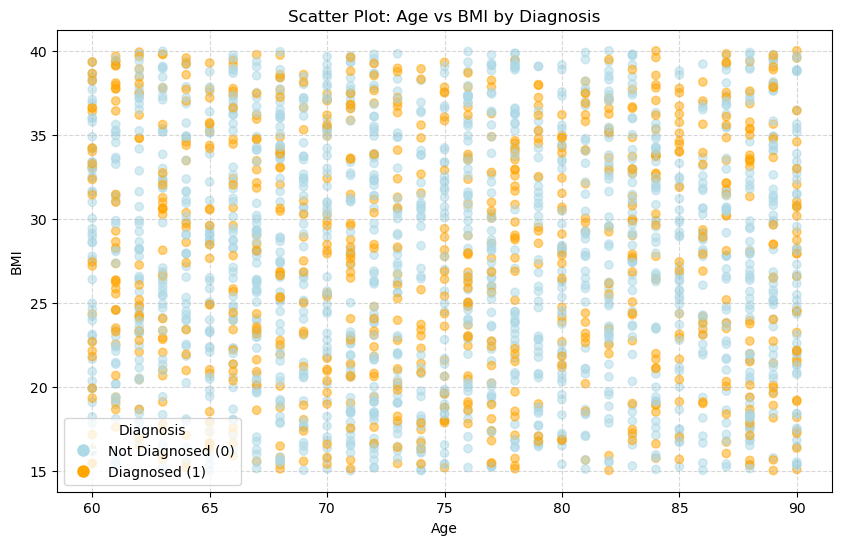

In [10]:
# Scatter plot for Age vs. BMI with Diagnosis as color
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df['Age'], 
    df['BMI'], 
    c=['lightblue' if diag == 0 else 'orange' for diag in df['Diagnosis']],
    alpha=0.5,
)

legend_labels = [mlines.Line2D([], [], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Not Diagnosed (0)'),
                 mlines.Line2D([], [], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Diagnosed (1)')]
plt.legend(handles=legend_labels, title='Diagnosis')

# Adding color bar and labels
plt.title('Scatter Plot: Age vs BMI by Diagnosis')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Conducting Student's t-t|st, we found that `MMSE`, `FunctionalAssessment` and `ADL` have extremely small p-values, which is expected as they are assessments directly used for diagnosis. The small p-values (p < 0.05) of `SleepQuality` and `CholesterolHDL` is however more insightful, suggesting they may significantly influence the likelihood of developing Alzheimer's disease.

In [11]:
# Separating the groups based on Diagnosis
diagnosed = df[df['Diagnosis'] == 1]
not_diagnosed = df[df['Diagnosis'] == 0]

# Initialize results dictionary
t_test_results = {}

# Perform T-tests for each numeric column
for col in numeric_columns:
    if col != 'Diagnosis':  # Exclude the target column
        t_stat, p_value = ttest_ind(diagnosed[col], not_diagnosed[col], nan_policy='omit')
        t_test_results[col] = {'T-statistic': t_stat, 'P-value': p_value}

# Display results
print("T-test Results:")
for col, stats in t_test_results.items():
    print(f"{col}: T-statistic = {stats['T-statistic']:.2f}, P-value = {stats['P-value']:.4f}")

T-test Results:
BMI: T-statistic = 1.22, P-value = 0.2222
AlcoholConsumption: T-statistic = -0.35, P-value = 0.7241
PhysicalActivity: T-statistic = 0.28, P-value = 0.7830
DietQuality: T-statistic = 0.39, P-value = 0.6935
SleepQuality: T-statistic = -2.62, P-value = 0.0087
CholesterolTotal: T-statistic = 0.30, P-value = 0.7670
CholesterolLDL: T-statistic = -1.48, P-value = 0.1384
CholesterolHDL: T-statistic = 1.97, P-value = 0.0484
CholesterolTriglycerides: T-statistic = 1.05, P-value = 0.2935
MMSE: T-statistic = -11.31, P-value = 0.0000
FunctionalAssessment: T-statistic = -18.16, P-value = 0.0000
ADL: T-statistic = -16.33, P-value = 0.0000
Age: T-statistic = -0.25, P-value = 0.7993
SystolicBP: T-statistic = -0.72, P-value = 0.4694
DiastolicBP: T-statistic = 0.25, P-value = 0.8063


We used box plots to visualize the five significant variables mentioned above. The differences between two diagonis goups in `SleepQuality` and `CholesterolHDL` are not significant but noticeable.

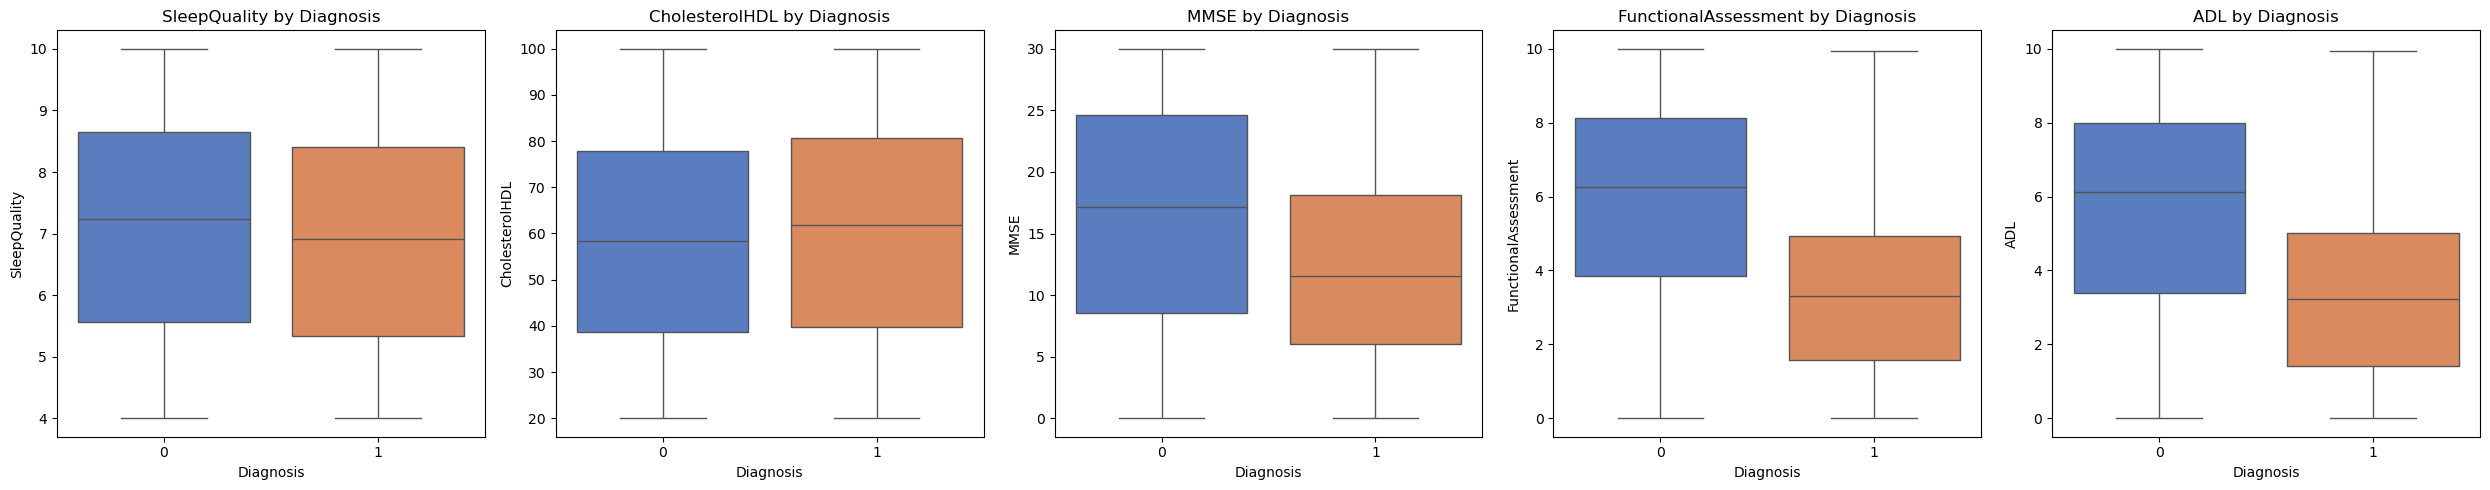

In [12]:
# Filtering significant variables
significant_vars = [col for col, stats in t_test_results.items() if stats['P-value'] < 0.05]
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=False)

# Loop through significant variables
for i, col in enumerate(significant_vars):
    sns.boxplot(data=df, x='Diagnosis', y=col, palette='muted', ax=axes[i])
    axes[i].set_title(f"{col} by Diagnosis")
    axes[i].set_xlabel("Diagnosis")
plt.tight_layout()
plt.show()

## Predictive Models

We trained and evaluated four predictive models as shown below.

In [13]:
X = scaled_df.drop(columns=['Diagnosis'])  # Predictors
y = scaled_df['Diagnosis']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),  # Scaling is important for LR
        ('model', LogisticRegression())
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
results = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train)  # Train the model
    y_pred = pipeline.predict(X_test)  # Predict on test data
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[model_name] = accuracy
    
    # Print classification report
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# Print overall results
print("Summary of Model Accuracies:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       278
           1       0.74      0.74      0.74       152

    accuracy                           0.82       430
   macro avg       0.80      0.80      0.80       430
weighted avg       0.82      0.82      0.82       430

--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       278
           1       0.83      0.86      0.85       152

    accuracy                           0.89       430
   macro avg       0.88      0.88      0.88       430
weighted avg       0.89      0.89      0.89       430

--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       278
           1       0.94      0.89      0.92       152

    accuracy     

According to both the logistic regression and the decision tree models, the five Cognitive and Functional Assessment features `FunctionalAssessment`, `ADL`, `MemoryComplaints`, `BehavioralProblems`, and `MMSE` contribute the most to our model, significantly surpassing all other features. This suggests that the final diagnosis may be directly derived from the results of these assessments.

In [14]:
# Check the coefficients of the logistic regression model
important_feat_lr = sorted(zip(
    models['Logistic Regression'].named_steps['model'].coef_[0],
    X.columns
), key=lambda t: abs(t[0]), reverse=True)

# Check the feature importance of the decision tree model
important_feat_dt = sorted(zip(
    models['Decision Tree'].feature_importances_,
    X.columns
), reverse=True)

print(important_feat_lr[:7])
print(important_feat_dt[:7])

[(-1.318723376086754, 'FunctionalAssessment'), (-1.2709133390638256, 'ADL'), (1.1372174158660078, 'MemoryComplaints'), (0.9280851834718691, 'BehavioralProblems'), (-0.8597950013014275, 'MMSE'), (0.1502186938932409, 'CholesterolHDL'), (-0.14995501583299645, 'CholesterolLDL')]
[(0.23584099064578712, 'MMSE'), (0.19864915747795764, 'ADL'), (0.18076795273959395, 'FunctionalAssessment'), (0.14148417484358478, 'MemoryComplaints'), (0.0989249920239703, 'BehavioralProblems'), (0.020023462285523125, 'DietQuality'), (0.01735346088990655, 'BMI')]


## Feature Selection 
After splitting, we selected the feature based on the train set to avoid data leakage.

In [15]:
# Define predictors (X) and target (y)
X = scaled_df.drop(columns=['Diagnosis'])  # Predictors
y = scaled_df['Diagnosis']  # Target

# Feature Selection
# Select the top k features based on ANOVA F-value
k = 10  # Choose the number of features to retain (adjust based on experimentation)
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features}")

# Check and convert target to discrete classes if necessary
print("Before processing, unique values in y:", y.unique())

# Example: Binarize continuous target (adjust the threshold as needed)
threshold = 0.5  # Modify based on your problem domain
if y.dtypes in ['float64', 'float32']:  # Check if y is continuous
    y = (y > threshold).astype(int)

print("After processing, unique values in y:", y.unique())

# Proceed with feature selection and train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

Selected features: Index(['EducationLevel', 'SleepQuality', 'FamilyHistoryAlzheimers',
       'Hypertension', 'CholesterolHDL', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL'],
      dtype='object')
Before processing, unique values in y: [0 1]
After processing, unique values in y: [0 1]


In [16]:
# Define the models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),  # Scaling is important for LR
        ('model', LogisticRegression())
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
results = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train) 
    y_pred = pipeline.predict(X_test)  
    accuracy = accuracy_score(y_test, y_pred) 
    results[model_name] = accuracy
    
    # Print classification report
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

print("Summary of Model Accuracies:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       278
           1       0.75      0.75      0.75       152

    accuracy                           0.82       430
   macro avg       0.81      0.81      0.81       430
weighted avg       0.82      0.82      0.82       430

--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       278
           1       0.88      0.89      0.88       152

    accuracy                           0.92       430
   macro avg       0.91      0.91      0.91       430
weighted avg       0.92      0.92      0.92       430

--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1       0.94      0.90      0.92       152

    accuracy     

After feature selection, the accuracy score for Random Forest is higher than XGBoost, unlike before feature selection.

>Logistic Regression 0.844 (0.028)
>Decision Tree 0.908 (0.020)
>XGBoost 0.947 (0.013)
>Random Forest 0.952 (0.012)
>Stacking 0.951 (0.011)


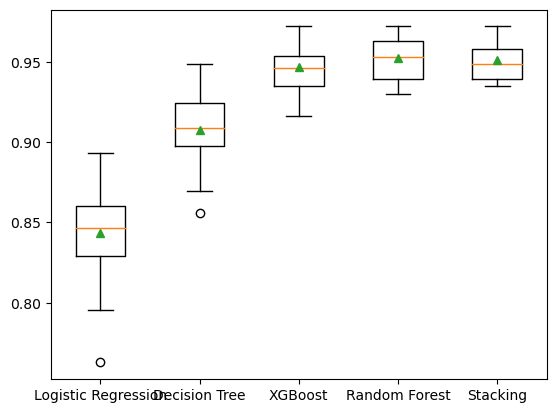

In [20]:
# compare ensemble to each baseline classifier
# get the dataset
def get_dataset():
	X = scaled_df.drop(columns=['Diagnosis'])  # Predictors
	y = scaled_df['Diagnosis']  # Target
	k = 10
	selector = SelectKBest(score_func=f_classif, k=k)
	X_selected = selector.fit_transform(X, y)
	threshold = 0.5  # Modify based on your problem domain
	if y.dtypes in ['float64', 'float32']:  # Check if y is continuous
		y = (y > threshold).astype(int)
	return X_selected, y
 
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('Logistic Regression', LogisticRegression()))
	level0.append(('Decision Tree', DecisionTreeClassifier()))
	level0.append(('XGBoost', XGBClassifier(eval_metric='logloss')))
	level0.append(('Random Forest', RandomForestClassifier()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	stack_models = dict()
	stack_models['Logistic Regression'] = LogisticRegression()
	stack_models['Decision Tree'] = DecisionTreeClassifier()
	stack_models['XGBoost'] = XGBClassifier(eval_metric='logloss')
	stack_models['Random Forest'] = RandomForestClassifier()
	stack_models['Stacking'] = get_stacking()
	return stack_models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X_selected, y = get_dataset()
# get the models to evaluate
stack_models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in stack_models.items():
	scores = evaluate_model(model, X_selected, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Then we sumerized the performance of each model with bar plot. We can see that random forest performs almost the same as stacking.

>Logistic Regression 0.844 (0.028)
>Decision Tree 0.909 (0.019)
>XGBoost 0.947 (0.013)
>Random Forest 0.952 (0.012)
>Stacking 0.951 (0.011)


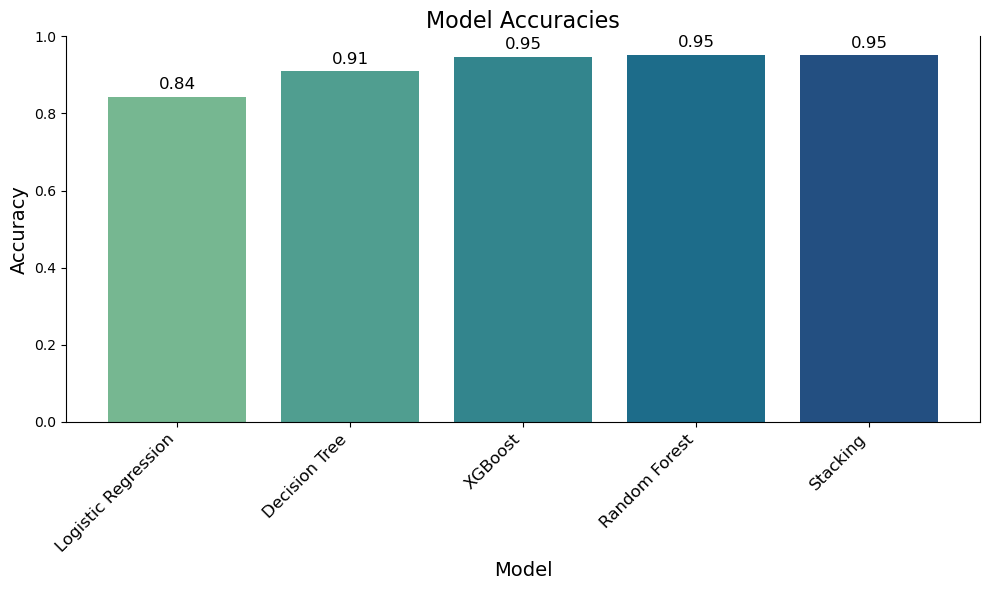

In [22]:
# Evaluate the models and store results in the dictionary
results = {}
for name, model in stack_models.items():
    scores = evaluate_model(model, X_selected, y)
    mean_accuracy = np.mean(scores)
    results[name] = mean_accuracy
    print('>%s %.3f (%.3f)' % (name, mean_accuracy, np.std(scores)))

# Prepare data for visualization
model_names = list(results.keys())
accuracies = list(results.values())

# Generate a Seaborn color palette
colors = sns.color_palette("crest", len(model_names))

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=colors)  # Use Seaborn colors
plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for accuracy range
plt.title("Model Accuracies", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# Add accuracy values on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)

# Remove the top line of the plot box
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)

# Show the plot
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.savefig("model_accuracies_with_stacking.jpg", format="jpg", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

We hyperparameter-tuned each model and reached the highest cross-validation accuracy of 0.9529 using random forest.

In [ ]:
# Tunning hyperparameter for Logistic Regression Model
# define dataset
X_selected, y = get_dataset()

# Define logistic regression model
lr_model = LogisticRegression(solver='liblinear')

# Define parameter grid for LR
lr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=lr_param_grid, cv=5,
                               scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_selected, y)

print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best cross-validation accuracy for Logistic Regression:", grid_search_lr.best_score_)


Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy for Logistic Regression: 0.8440678701143817


In [ ]:
# Tunning hyperparameter for Logistic Regression Model - Elastic Net
X_selected, y = get_dataset()

# Define logistic regression model
elastic_model = LogisticRegression(solver='saga', max_iter=500)

# Define parameter grid for LR
elastic_param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['elasticnet'],
    'l1_ratio': [0.2, 0.5, 0.8]
}

grid_search_elastic = GridSearchCV(estimator=elastic_model, param_grid=elastic_param_grid, cv=5,
                               scoring='accuracy', n_jobs=-1)
grid_search_elastic.fit(X_selected, y)

print("Best parameters for Elastic Net:", grid_search_elastic.best_params_)
print("Best cross-validation accuracy for Elastic Net:", grid_search_elastic.best_score_)

Best parameters for Elastic Net: {'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
Best cross-validation accuracy for Elastic Net: 0.8445308180191902


In [ ]:
# Tunning hyperparameter 
# define dataset
X_selected, y = get_dataset()

# Tune hyperparameters for XGBoost
xgb = XGBClassifier(eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5,
                               scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_selected, y)

print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best cross-validation accuracy for XGBoost:", grid_search_xgb.best_score_)


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation accuracy for XGBoost: 0.9524714045644277


In [ ]:
# Tune hyperparameters for Random Forest
rf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [150, 180, 200, 250],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [1, 2, 3, 5],
    'max_features': ['auto', 'sqrt']
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5,
                              scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_selected, y)

print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation accuracy for Random Forest:", grid_search_rf.best_score_)


Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}
Best cross-validation accuracy for Random Forest: 0.9529376050306283


In [ ]:
# Tune hyperparameters for StackingClassifier
# Define base estimators
level0 = [
    ('lr', LogisticRegression()),
    ('cart', DecisionTreeClassifier()),
    ('XGBoost', XGBClassifier(eval_metric='logloss')),
    ('rf', RandomForestClassifier())
]
# Define meta learner
level1 = LogisticRegression()

stacking_clf = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

# Define parameter grid
stacking_param_grid = {
    'final_estimator__C': [0.1, 1.0, 10.0],
    'XGBoost__n_estimators': [50, 100],
    'XGBoost__max_depth': [3, 5],
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 5],
    'cart__max_depth': [None, 5, 10]
}

grid_search_stacking = GridSearchCV(estimator=stacking_clf, param_grid=stacking_param_grid, cv=5,
                                    scoring='accuracy', n_jobs=-1)
grid_search_stacking.fit(X_selected, y)

print("Best parameters for StackingClassifier:", grid_search_stacking.best_params_)
print("Best cross-validation accuracy for StackingClassifier:", grid_search_stacking.best_score_)

Best parameters for StackingClassifier: {'XGBoost__max_depth': 3, 'XGBoost__n_estimators': 100, 'cart__max_depth': 10, 'final_estimator__C': 10.0, 'rf__max_depth': None, 'rf__n_estimators': 100}
Best cross-validation accuracy for StackingClassifier: 0.9520073724724887


In addition, we made predictive models based on various feature categories, namely only a portion of features.

In [ ]:
# Define feature categories
categories = {
    "Demographic": ['EducationLevel', 'FamilyHistoryAlzheimers'],
    "Lifestyle": ['SleepQuality', 'MemoryComplaints'],
    "Medical": ['Hypertension', 'CholesterolHDL', 'BehavioralProblems'],
    "Cognitive": ['MMSE', 'FunctionalAssessment', 'ADL'],
    "No_Cognitive_or_Clinical": ['Hypertension', 'BehavioralProblems', 'EducationLevel',
                    'FamilyHistoryAlzheimers','SleepQuality', 'MemoryComplaints']
}

# Iterate through each category, subset the data, and run the models
results_by_category = {}

for category, features in categories.items():
    print(f"\n### Predictions based on {category} features ###")
    
    # Subset the data
    X_category = scaled_df[features]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_category, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train and evaluate models
    results = {}
    for model_name, pipeline in models.items():
        pipeline.fit(X_train, y_train)  # Train the model
        y_pred = pipeline.predict(X_test)  # Predict on test data
        accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
        results[model_name] = accuracy

        # Print classification report
        print(f"Model: {model_name}")
        print(classification_report(y_test, y_pred))
        print("-" * 50)
    
    # Store results for this category
    results_by_category[category] = results

# Print overall results for each category
print("Summary of Model Accuracies by Feature Category:")
for category, result in results_by_category.items():
    print(f"\n{category}:")
    for model, accuracy in result.items():
        print(f"{model}: {accuracy:.4f}")


### Predictions based on Demographic features ###
Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430

--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430

--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.

In [ ]:
# Hyperparameter Tuning for Categories
# Define hyperparameter grids
log_reg_param_grid = {
    'C': [0.1, 1, 10], 
    'penalty': ['l1', 'l2'], 
    'solver': ['liblinear']
}

elastic_net_param_grid = {
    'C': [0.1, 1, 10], 
    'penalty': ['elasticnet'], 
    'l1_ratio': [0.2, 0.5, 0.8], 
    'solver': ['saga'],
    'max_iter': [500]
}

random_forest_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Results dictionary
results_by_category_tuning = {}

# Iterate through each category
for category, features in categories.items():
    print(f"\n### Predictions based on {category} features ###")

    # Subset the data
    X_category = scaled_df[features]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_category, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Results for this category
    results = {}
    
    # Logistic Regression
    log_reg = LogisticRegression()
    grid_search_log_reg = GridSearchCV(
        estimator=log_reg, param_grid=log_reg_param_grid, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    grid_search_log_reg.fit(X_train, y_train)
    y_pred = grid_search_log_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results['Logistic Regression'] = {
        'accuracy': accuracy,
        'best_params': grid_search_log_reg.best_params_
    }
    print(f"Best parameters for Logistic Regression: {grid_search_log_reg.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Elastic Net
    elastic_net = LogisticRegression()
    grid_search_elastic_net = GridSearchCV(
        estimator=elastic_net, param_grid=elastic_net_param_grid, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    grid_search_elastic_net.fit(X_train, y_train)
    y_pred = grid_search_elastic_net.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results['Elastic Net'] = {
        'accuracy': accuracy,
        'best_params': grid_search_elastic_net.best_params_
    }
    print(f"Best parameters for Elastic Net: {grid_search_elastic_net.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Random Forest
    rf = RandomForestClassifier(random_state=42)
    grid_search_rf = GridSearchCV(
        estimator=rf, param_grid=random_forest_param_grid, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    grid_search_rf.fit(X_train, y_train)
    y_pred = grid_search_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results['Random Forest'] = {
        'accuracy': accuracy,
        'best_params': grid_search_rf.best_params_
    }
    print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # XGBoost
    xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
    grid_search_xgb = GridSearchCV(
        estimator=xgb, param_grid=xgb_param_grid, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    grid_search_xgb.fit(X_train, y_train)
    y_pred = grid_search_xgb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results['XGBoost'] = {
        'accuracy': accuracy,
        'best_params': grid_search_xgb.best_params_
    }
    print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Store results for this category
    results_by_category_tuning[category] = results

# Print summary of results
print("\nSummary of Model Accuracies by Feature Category:")
for category, result in results_by_category_tuning.items():
    print(f"\n{category}:")
    for model, metrics in result.items():
        print(f"{model}: Accuracy = {metrics['accuracy']:.4f}, Best Params = {metrics['best_params']}")




### Predictions based on Demographic features ###
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.6465
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430

Best parameters for Elastic Net: {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga'}
Accuracy: 0.6465
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430

Best parameters for Random Forest: {'max_depth':

Visualize Model Accuracies

                          Logistic Regression  Decision Tree   XGBoost  \
Demographic                          0.646512       0.646512  0.646512   
Lifestyle                            0.679070       0.593023  0.655814   
Medical                              0.693023       0.574419  0.644186   
Cognitive                            0.795349       0.758140  0.809302   
No_Cognitive_or_Clinical             0.704651       0.604651  0.688372   

                          Random Forest  
Demographic                    0.646512  
Lifestyle                      0.590698  
Medical                        0.576744  
Cognitive                      0.818605  
No_Cognitive_or_Clinical       0.602326  


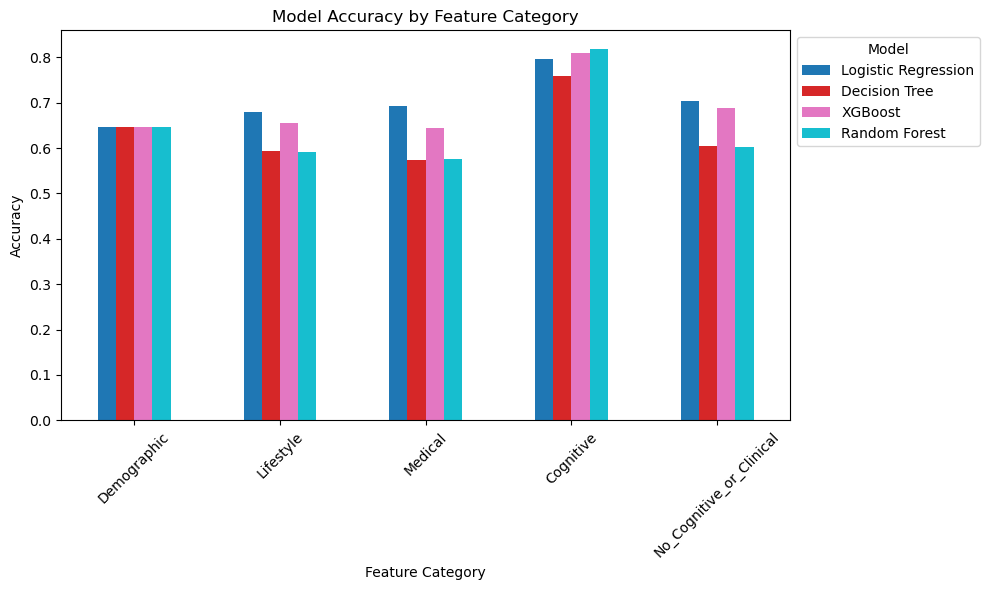

In [ ]:
# converting results to a DataFrame for easy visualization
# .T - # Transpose for better readability
results_df = pd.DataFrame(results_by_category).T  
print(results_df)

# bar chart
results_df.plot(kind='bar', figsize=(10, 6), colormap='tab10')
plt.title("Model Accuracy by Feature Category")
plt.ylabel("Accuracy")
plt.xlabel("Feature Category")
plt.xticks(rotation=45)
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  
plt.show()

Accuracy DataFrame:
                           Logistic Regression  Elastic Net  Random Forest  \
Demographic                          0.646512     0.646512       0.646512   
Lifestyle                            0.679070     0.679070       0.672093   
Medical                              0.693023     0.693023       0.648837   
Cognitive                            0.795349     0.795349       0.837209   
No_Cognitive_or_Clinical             0.704651     0.704651       0.672093   

                           XGBoost  
Demographic               0.646512  
Lifestyle                 0.676744  
Medical                   0.665116  
Cognitive                 0.837209  
No_Cognitive_or_Clinical  0.711628  


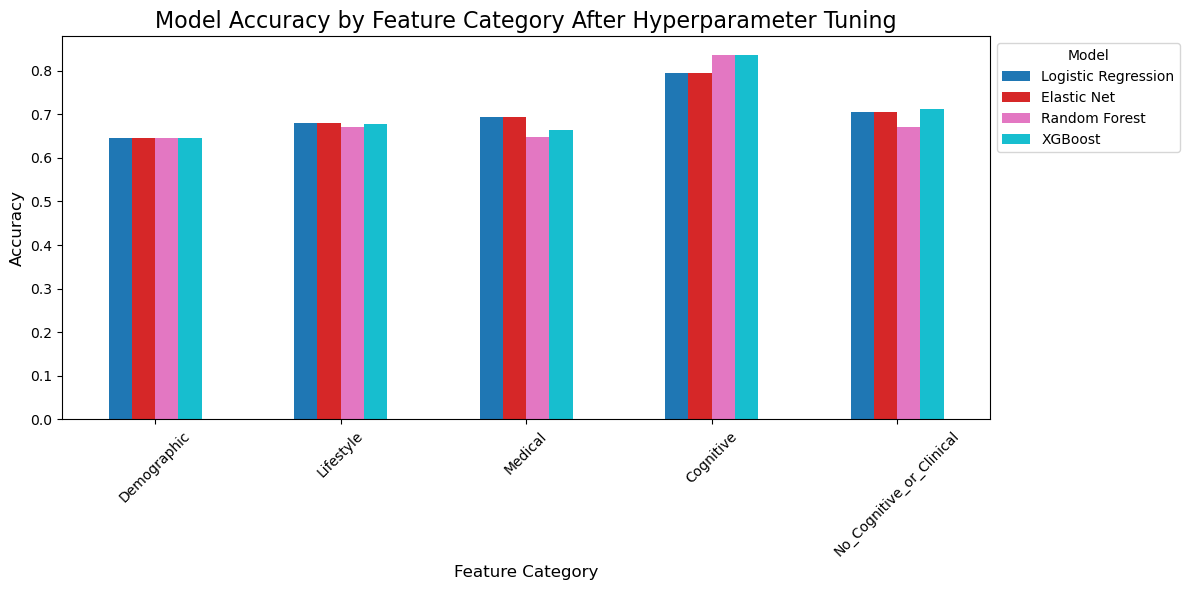

In [ ]:
# Extract accuracy values into a DataFrame
results_df_tuning = pd.DataFrame({
    category: {model: metrics['accuracy'] for model, metrics in result.items()}
    for category, result in results_by_category_tuning.items()
}).T  # Transpose for better readability

# Display the DataFrame
print("Accuracy DataFrame:\n", results_df_tuning)

# Plot the accuracies as a bar chart
results_df_tuning.plot(kind='bar', figsize=(12, 6), colormap='tab10')
plt.title("Model Accuracy by Feature Category After Hyperparameter Tuning", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Feature Category", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.savefig("model_accuracy_hyperparameter_tuning.jpg")
plt.show()
